In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# to make a csr matrix (for fast count estimation) will be used libs below
from scipy import sparse
from pandas.api.types import CategoricalDtype

In [2]:
position_changes_df = pd.read_csv("position_changes.csv")
position_changes_df.drop(columns=["Unnamed: 0"], inplace=True)
position_changes_df["time"] = pd.to_datetime(position_changes_df["timestamp"], unit='s')
position_changes_df["day_of_year"] = position_changes_df["time"].dt.dayofyear

In [3]:
tokens_addresses_to_names_dict = {
    "0x86f1e0420c26a858fc203a3645dd1a36868f18e5": "vBTC",
    "0x8c835dfaa34e2ae61775e80ee29e2c724c6ae2bb": "vETH",
    "0x5faa136fc58b6136ffdaeaac320076c4865c070f": "vAVAX",
    "0xb24f50dd9918934ab2228be7a097411ca28f6c14": "vLUNA",
    "0x151bb01c79f4516c233948d69dae39869bccb737": "vSOL",
    "0x7161c3416e08abaa5cd38e68d9a28e43a694e037": "vCRV",
    "0x333b1ea429a88d0dd48ce7c06c16609cd76f43a8": "vSAND",
    "0x2f198182ec54469195a4a06262a9431a42462373": "vLINK",
    "0x5f714b5347f0b5de9f9598e39840e176ce889b9c": "vATOM",
    "0x77d0cc9568605bfff32f918c8ffaa53f72901416": "vONE",
    "0x3fb3282e3ba34a0bff94845f1800eb93cc6850d4": "vNEAR",
    "0x2db8d2db86ca3a4c7040e778244451776570359b": "vFTM",
    "0x7eada83e15acd08d22ad85a1dce92e5a257acb92": "vFLOW",
    "0xb6599bd362120dc70d48409b8a08888807050700": "vBNB",
    "0x9482aafdced6b899626f465e1fa0cf1b1418d797": "vPERP",
    "0xbe5de48197fc974600929196239e264ecb703ee8": "vMATIC",
    "0x34235c8489b06482a99bb7fcab6d7c467b92d248": "vAAVE",
    "0x9d34f1d15c22e4c0924804e2a38cbe93dfb84bc2": "vAPE"
}

position_changes_df["pool_name"] = position_changes_df["base_token"].replace(tokens_addresses_to_names_dict)

# CSR

In [4]:
amm_trader_list = []

for amm in position_changes_df['pool_name'].unique():
    amm_story = position_changes_df[position_changes_df['pool_name'] == amm]
    amm_trader_df = pd.DataFrame(columns=['pool_name', 'trader'])
    amm_trader_df['trader'] = amm_story['trader'].unique()
    amm_trader_df['pool_name'] = [amm] * len(amm_story['trader'].unique())
    amm_trader_list.append(amm_trader_df)
    
traders_amm_df = pd.concat(amm_trader_list)
traders_amm_df["count"] = [1] * len(traders_amm_df)
traders_amm_df

,pool_name,trader,count
0,vBTC,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,1
1,vBTC,0xd087966b4d2b1841c88b4d62b407d5ef1a465ac3,1
2,vBTC,0x35952141922ee99a04e016c967c3f0ad589ea958,1
3,vBTC,0xefc0d892656eeb59a0b54a6b4f2a0d2fad4b66c8,1
4,vBTC,0x02cc0130ffedf077a848606b7a3e018f7f7434af,1
...,...,...,...
70,vAPE,0x03853b09108931c5c8ff9b1a7de689e7e76e7711,1
71,vAPE,0xa2a317609015cd0b1ea92d323ec500664d98cfe6,1
72,vAPE,0xea414355a738d5715379db885db889049c20fc92,1
73,vAPE,0xbfd14e128873f89861ce7cf6d1b80afe10847e60,1


In [5]:
users = traders_amm_df["trader"].unique()
amms = traders_amm_df["pool_name"].unique()
shape = (len(users), len(amms))

user_cat = CategoricalDtype(categories=sorted(users), ordered=True)
amms_cat = CategoricalDtype(categories=sorted(amms), ordered=True)

user_index = traders_amm_df["trader"].astype(user_cat).cat.codes
amm_index = traders_amm_df["pool_name"].astype(amms_cat).cat.codes

# Conversion via COO matrix
coo = sparse.coo_matrix((traders_amm_df["count"], (user_index, amm_index)), shape=shape)
csr = coo.tocsr()

In [6]:
stats_df = pd.DataFrame.sparse.from_spmatrix(csr, columns=amms_cat.categories)
stats_df.index = user_cat.categories
stats_df['occurencies_sum'] = stats_df.sum(axis=1)
stats_df

,vAAVE,vAPE,vATOM,vAVAX,vBNB,vBTC,vCRV,vETH,vFLOW,vFTM,vLINK,vLUNA,vMATIC,vNEAR,vONE,vPERP,vSAND,vSOL,occurencies_sum
0x000000000a38444e0a6e37d3b630d7e855a7cb13,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,2
0x00004bbaaa33277a699146f220c2edc01ae96501,0,0,1,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,5
0x00069a4bf1b2a8d5eded8e91347dbaa70796ff54,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
0x000872be5ec7dc8197ef6618ef507d9a449cac1a,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
0x000ed00d03833d52ca64312387a0a08e6ef57f76,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xffdf4eb71c453bebc5e2672d70c1330164683071,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
0xffeb037c74faf4466edd9554d4e281b93ab2ff26,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
0xffee0f6a4aff3e9644a6bb3239f3fb4ee32482e7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
0xfff69ccaffd53e68b056d0e7d24fc941b033eec3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


# Reviewing traders separation by pool

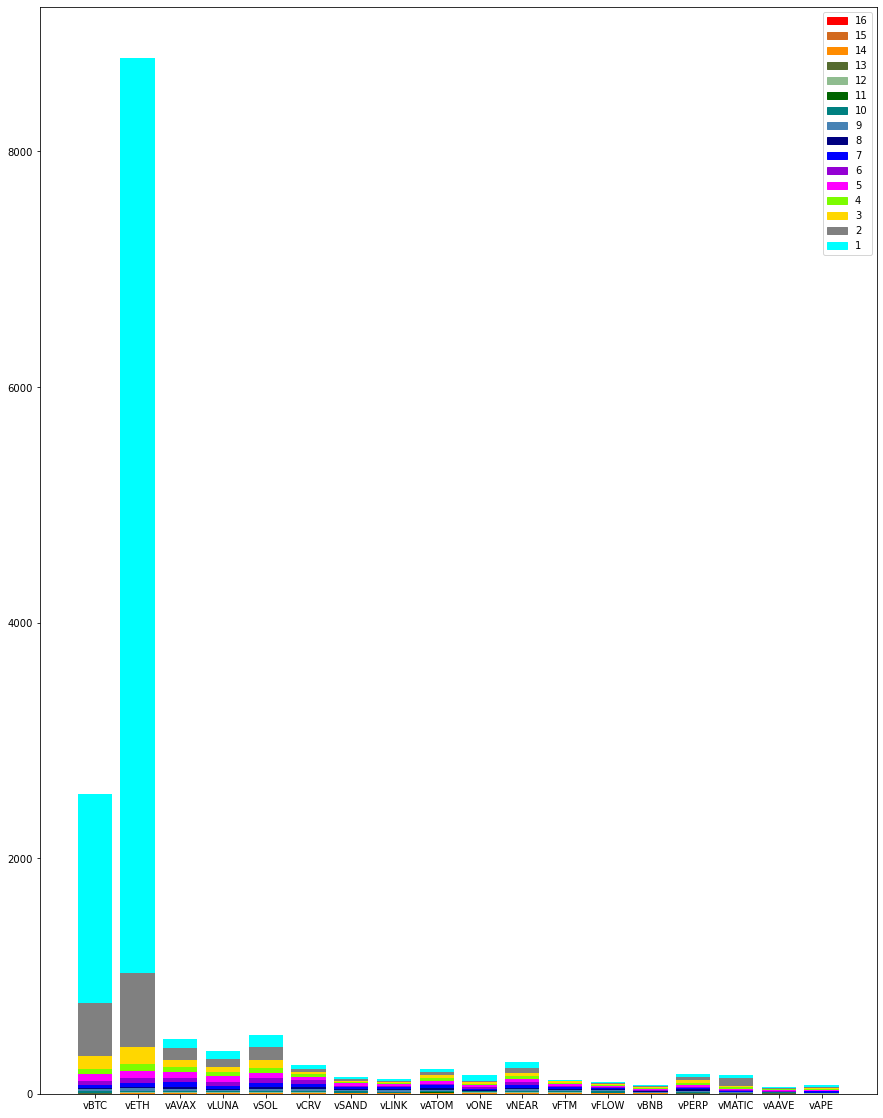

In [7]:
fig, ax = plt.subplots(figsize=(15, 20))
colors = ["pink", "aqua", "gray", "gold", "lawngreen", "fuchsia", "darkviolet", "blue", "navy", "steelblue",
          "teal", "darkgreen", "darkseagreen", "darkolivegreen", "darkorange", "chocolate", "red"]
bottoms = np.zeros(18)
patches_list = []

for occurencies_count in range(stats_df["occurencies_sum"].max(), 0, -1):
    occurencies_stats_df = stats_df[stats_df["occurencies_sum"] == occurencies_count]
    index = 0
    for pool_name in position_changes_df["pool_name"].unique():
        ax.bar(pool_name, len(occurencies_stats_df[occurencies_stats_df[pool_name] == 1]), color=colors[occurencies_count], 
               bottom=bottoms[index])
        bottoms[index] += len(occurencies_stats_df[occurencies_stats_df[pool_name] == 1])
        index += 1
        
    patches_list.append(mpatches.Patch(color=colors[occurencies_count], label=str(occurencies_count)))
        
ax.legend(handles=patches_list)
plt.show()

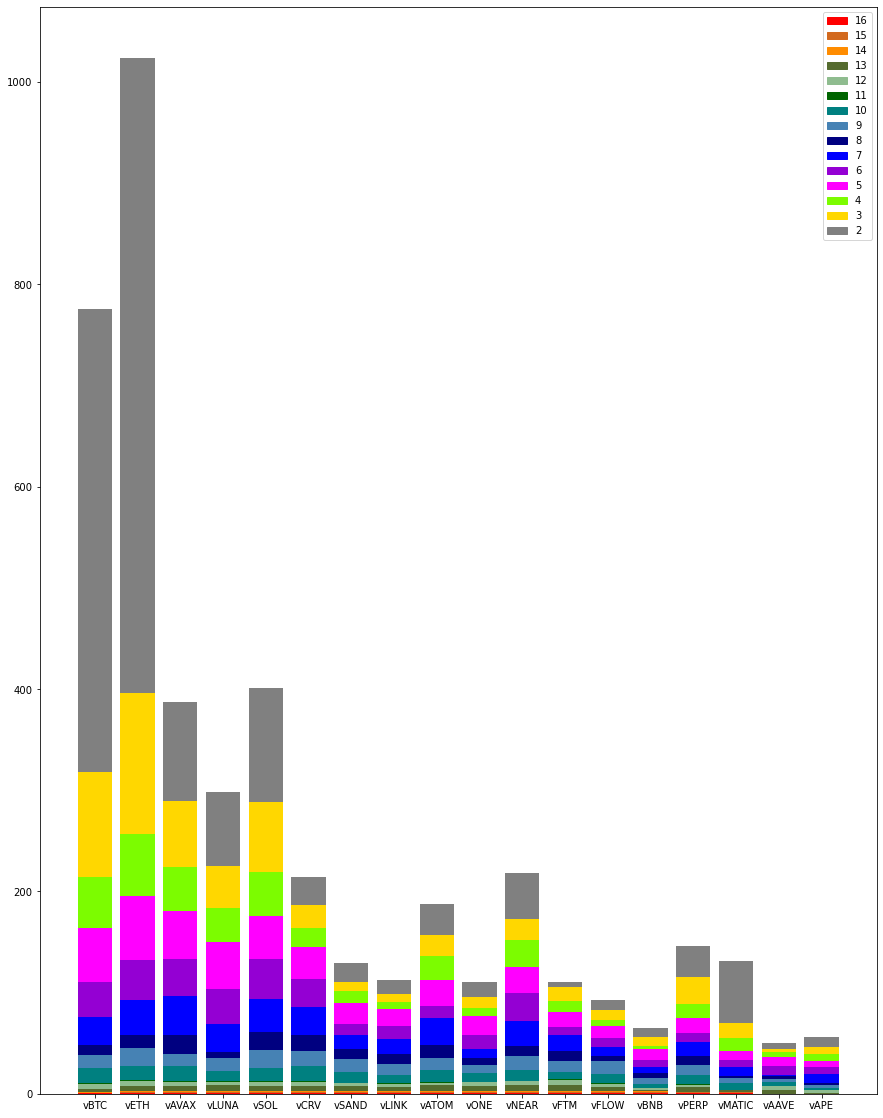

In [8]:
fig, ax = plt.subplots(figsize=(15, 20))
colors = ["pink", "aqua", "gray", "gold", "lawngreen", "fuchsia", "darkviolet", "blue", "navy", "steelblue",
          "teal", "darkgreen", "darkseagreen", "darkolivegreen", "darkorange", "chocolate", "red"]
bottoms = np.zeros(18)
patches_list = []

for occurencies_count in range(stats_df["occurencies_sum"].max(), 1, -1):
    occurencies_stats_df = stats_df[stats_df["occurencies_sum"] == occurencies_count]
    index = 0
    for pool_name in position_changes_df["pool_name"].unique():
        ax.bar(pool_name, len(occurencies_stats_df[occurencies_stats_df[pool_name] == 1]), color=colors[occurencies_count], 
               bottom=bottoms[index])
        bottoms[index] += len(occurencies_stats_df[occurencies_stats_df[pool_name] == 1])
        index += 1
        
    patches_list.append(mpatches.Patch(color=colors[occurencies_count], label=str(occurencies_count)))
        
ax.legend(handles=patches_list)
plt.show()

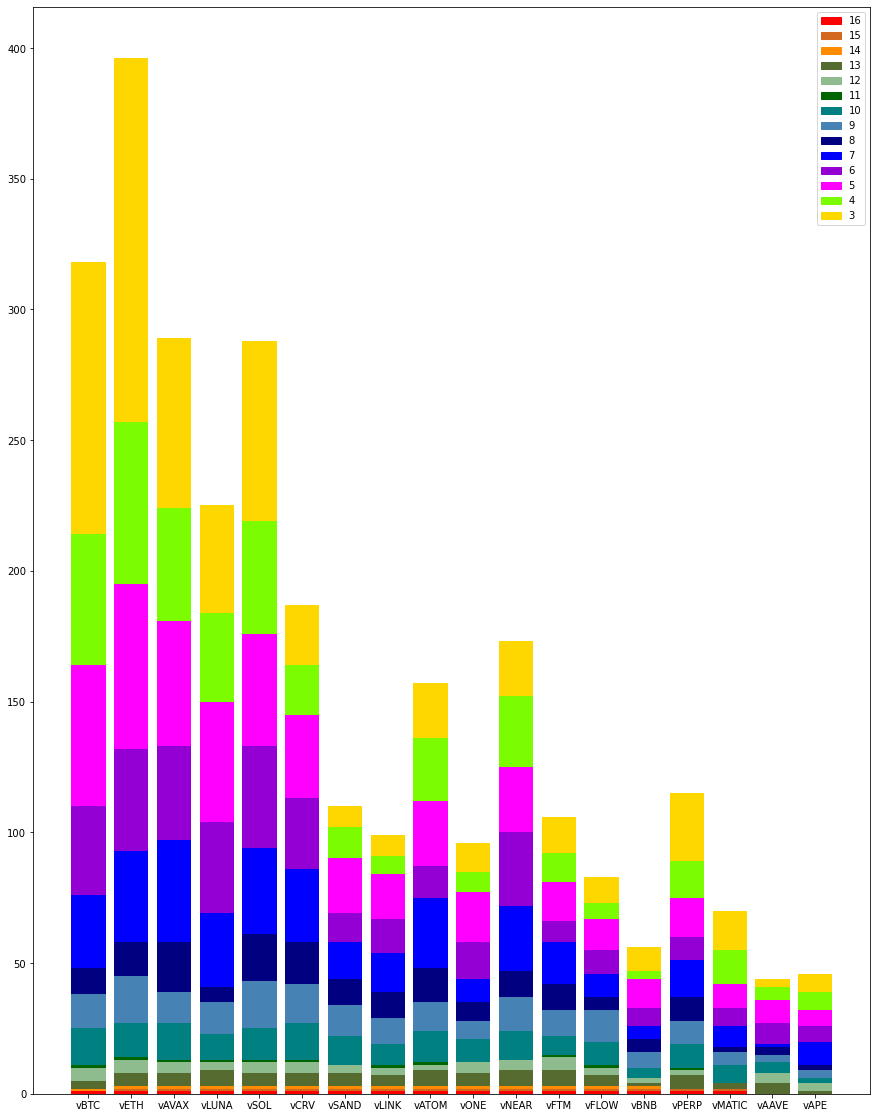

In [9]:
fig, ax = plt.subplots(figsize=(15, 20))
colors = ["pink", "aqua", "gray", "gold", "lawngreen", "fuchsia", "darkviolet", "blue", "navy", "steelblue",
          "teal", "darkgreen", "darkseagreen", "darkolivegreen", "darkorange", "chocolate", "red"]
bottoms = np.zeros(18)
patches_list = []

for occurencies_count in range(stats_df["occurencies_sum"].max(), 2, -1):
    occurencies_stats_df = stats_df[stats_df["occurencies_sum"] == occurencies_count]
    index = 0
    for pool_name in position_changes_df["pool_name"].unique():
        ax.bar(pool_name, len(occurencies_stats_df[occurencies_stats_df[pool_name] == 1]), color=colors[occurencies_count], 
               bottom=bottoms[index])
        bottoms[index] += len(occurencies_stats_df[occurencies_stats_df[pool_name] == 1])
        index += 1
        
    patches_list.append(mpatches.Patch(color=colors[occurencies_count], label=str(occurencies_count)))
        
ax.legend(handles=patches_list)
plt.show()

# Check of the best and worst traders out of all

In [10]:
top_pools_names = ["vBTC", "vETH", "vPERP", "vMATIC", "vLUNA", "vAVAX"]
list_of_top_traders = []

for pool in top_pools_names:
    top_pool_position_changes_df = position_changes_df[position_changes_df["pool_name"] == pool]
    traders_top_pool_data = top_pool_position_changes_df[["trader", "realized_pnl"]].groupby("trader").sum(
                                                                                    ).sort_values("realized_pnl")
    top_pool_lossers = traders_top_pool_data.head(10).index
    top_pool_profiters = traders_top_pool_data.tail(10).index
    list_of_top_traders.extend(top_pool_lossers)
    list_of_top_traders.extend(top_pool_profiters)
    
clean_list_top_traders = list(set(list_of_top_traders))
len(clean_list_top_traders)

90

In [11]:
top_traders = position_changes_df[["trader", "realized_pnl"]].groupby("trader").sum().sort_values("realized_pnl")
top_traders

,realized_pnl
trader,
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,-3.387945e+06
0xf8489bcef22d3282bb884b9e9cc708bb465c075e,-1.466126e+06
0x9455b22685036d89874296460fb28de8a70a6a66,-6.883971e+05
0x70332de459d5554a9a310a7c4f7c6069c73604f9,-6.542422e+05
0x4cd804c696f54c419b75fc241a17c512bfb13df4,-6.213989e+05
...,...
0x36209cad56c31332d575bed3e989c988c2ad8eee,1.602574e+05
0x57944fba39b44189f7173e70cf9ed99f2395283a,1.890892e+05
0x6541e4d0f50a82544401b1e0721626415a37de99,1.956091e+05


In [12]:
top_traders.tail(1).isin(clean_list_top_traders)

,realized_pnl
trader,
0x8a7cd6f15877a49f91189d311f026eb929228448,False


In [13]:
top_profiters = top_traders.tail(10).index
top_lossers = top_traders.head(10).index

In [14]:
stats_df[stats_df.index.isin(top_profiters)]

,vAAVE,vAPE,vATOM,vAVAX,vBNB,vBTC,vCRV,vETH,vFLOW,vFTM,vLINK,vLUNA,vMATIC,vNEAR,vONE,vPERP,vSAND,vSOL,occurencies_sum
0x06b23dc3fb948fd800dcad8a800b60fd0e5401bc,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2
0x36209cad56c31332d575bed3e989c988c2ad8eee,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2
0x475260834a8bbc65a7b2f057e768ab379d825d3e,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,3
0x57944fba39b44189f7173e70cf9ed99f2395283a,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
0x6541e4d0f50a82544401b1e0721626415a37de99,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,7
0x8a7cd6f15877a49f91189d311f026eb929228448,0,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,1,7
0x8c62b7696b09d7811e84a691baa6aec72ab7bb18,0,0,0,1,0,1,1,1,0,0,1,1,0,0,0,0,0,1,7
0x8de2e51c5e84df78fabce4134afe27b3f0116d4c,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2
0x91d46a68324991f2e96f121317b642a8d4179190,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
0xebd29307345ee6aec943129d9bb44120554efaac,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2


Top profiters are operating mostly on:

1. vBTC
2. vETH
3. vAVAX

In [15]:
stats_df[stats_df.index.isin(top_lossers)]

,vAAVE,vAPE,vATOM,vAVAX,vBNB,vBTC,vCRV,vETH,vFLOW,vFTM,vLINK,vLUNA,vMATIC,vNEAR,vONE,vPERP,vSAND,vSOL,occurencies_sum
0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,3
0x4cd804c696f54c419b75fc241a17c512bfb13df4,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,3
0x70332de459d5554a9a310a7c4f7c6069c73604f9,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,3
0x7c132bde28ad1e0101d45121757d7c6c2e8a550a,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2
0x9455b22685036d89874296460fb28de8a70a6a66,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0,0,0,1,0,1,1,1,0,0,0,1,0,0,0,0,0,1,6
0xbe18a60fd4c562e996fb6d59f22582c36759b970,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,3
0xd8bcd1e2f0e96a3402fd678b0b2eaceb80e1c226,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3
0xe77dd81813bd06d74a30d1b2c07418906456498e,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,3
0xf8489bcef22d3282bb884b9e9cc708bb465c075e,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3


Top lossers operate mostly on:

1. vBTC
2. vETH
3. evenly between vATOM, vAVAX, vFTM, vLINK, vLUNA, vNEAR, vONE, vSAND, vSOL

# Checking progression and results of the best traders on all pools

In [16]:
position_changes_df

,id,tx_hash,trader,base_token,exchanged_position_size,exchanged_position_notional,fee,open_notional,realized_pnl,position_size_after,swapped_price,entry_price_after,market_price_after,from_function_signature,block_number_log_index,block_number,timestamp,time,day_of_year,pool_name
0,0x0bc364e9f5a99c87cfb5c1f4a6ef2b9784e872092805...,0x0bc364e9f5a99c87cfb5c1f4a6ef2b9784e872092805...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0x86f1e0420c26a858fc203a3645dd1a36868f18e5,0.055019,-2997.000000,3.000000,-15000.000000,0.000000,0.275492,54472.154115,54448.103193,54491.778871,0xb6b1b6c3,515608004,515608,1638001140,2021-11-27 08:19:00,331,vBTC
1,0x0ccfa4751250a5374b5d28823a1011987b833f71a1ce...,0x0ccfa4751250a5374b5d28823a1011987b833f71a1ce...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0x86f1e0420c26a858fc203a3645dd1a36868f18e5,0.055098,-2997.000000,3.000000,-9000.000000,0.000000,0.165414,54393.697496,54408.885139,54413.308117,0xb6b1b6c3,515587004,515587,1638001140,2021-11-27 08:19:00,331,vBTC
2,0x0e085ae4b7c345ee6de6d67f16c8c127a694d1c9f27f...,0x0e085ae4b7c345ee6de6d67f16c8c127a694d1c9f27f...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0x8c835dfaa34e2ae61775e80ee29e2c724c6ae2bb,0.729828,-2997.000000,3.000000,-3000.000000,0.000000,0.729828,4106.445744,4110.556300,4108.035203,0xb6b1b6c3,515571005,515571,1638001140,2021-11-27 08:19:00,331,vETH
3,0x47357bec5ee7101b57f457be5135c91a9c7133cc82bb...,0x47357bec5ee7101b57f457be5135c91a9c7133cc82bb...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0x8c835dfaa34e2ae61775e80ee29e2c724c6ae2bb,0.728137,-2997.000000,3.000000,-12000.000000,0.000000,2.915928,4115.986193,4115.327606,4117.577498,0xb6b1b6c3,515594004,515594,1638001140,2021-11-27 08:19:00,331,vETH
4,0x548dd8a96b9faa92066283339832e380fd506f4ebc94...,0x548dd8a96b9faa92066283339832e380fd506f4ebc94...,0x9c1e0c67aa30c063f341885b12cb81cc94613fc7,0x8c835dfaa34e2ae61775e80ee29e2c724c6ae2bb,0.729264,-2997.000000,3.000000,-6000.000000,0.000000,1.459092,4109.624663,4112.146735,4111.214738,0xb6b1b6c3,515584004,515584,1638001140,2021-11-27 08:19:00,331,vETH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1834858,0xd91c7e2a87ab9380062386239788915e4f1c5a052fc8...,0xd91c7e2a87ab9380062386239788915e4f1c5a052fc8...,0xbca93564bbf750e7b81ee1506009c7d86c6a4a45,0xb24f50dd9918934ab2228be7a097411ca28f6c14,-32.999902,3023.793838,3.023794,-14962.556823,-9.172361,162.961152,91.630389,91.816710,91.582076,0xb6b1b6c3,6651587008,6651587,1651138134,2022-04-28 09:28:54,118,vLUNA
1834859,0x1ec3f79f957587b332572447f288b15ad1196a7e760a...,0x1ec3f79f957587b332572447f288b15ad1196a7e760a...,0x6f2ddd6d04aa4ebaa6e9529e8a1b4062a2716281,0x9d34f1d15c22e4c0924804e2a38cbe93dfb84bc2,128.952896,-2594.732513,2.597330,8420.360981,-0.556983,-418.145904,20.121553,20.137375,20.132960,0xb6b1b6c3,6651597008,6651597,1651138149,2022-04-28 09:29:09,118,vAPE
1834860,0x5d9e91d0e0f32cfd68a39c001e3c1a3a77f7d629b48c...,0x5d9e91d0e0f32cfd68a39c001e3c1a3a77f7d629b48c...,0x4b4f526b450c75f3cb0e9aa0a0b5480e4b0c478a,0x151bb01c79f4516c233948d69dae39869bccb737,-25.872016,2596.910612,2.596911,7150.315804,0.000000,-71.290018,100.375270,100.298977,100.362358,0xb6b1b6c3,6651599007,6651599,1651138149,2022-04-28 09:29:09,118,vSOL
1834861,0x978645e43b1779dae628ed4df8a0350803d161c8fef1...,0x978645e43b1779dae628ed4df8a0350803d161c8fef1...,0xd8bcd1e2f0e96a3402fd678b0b2eaceb80e1c226,0xbe5de48197fc974600929196239e264ecb703ee8,3371.136364,-4297.643387,0.000000,85634.249350,-31.434297,-67667.741060,1.274835,1.265511,1.273833,0xcde109b6,6651595007,6651595,1651138149,2022-04-28 09:29:09,118,vMATIC


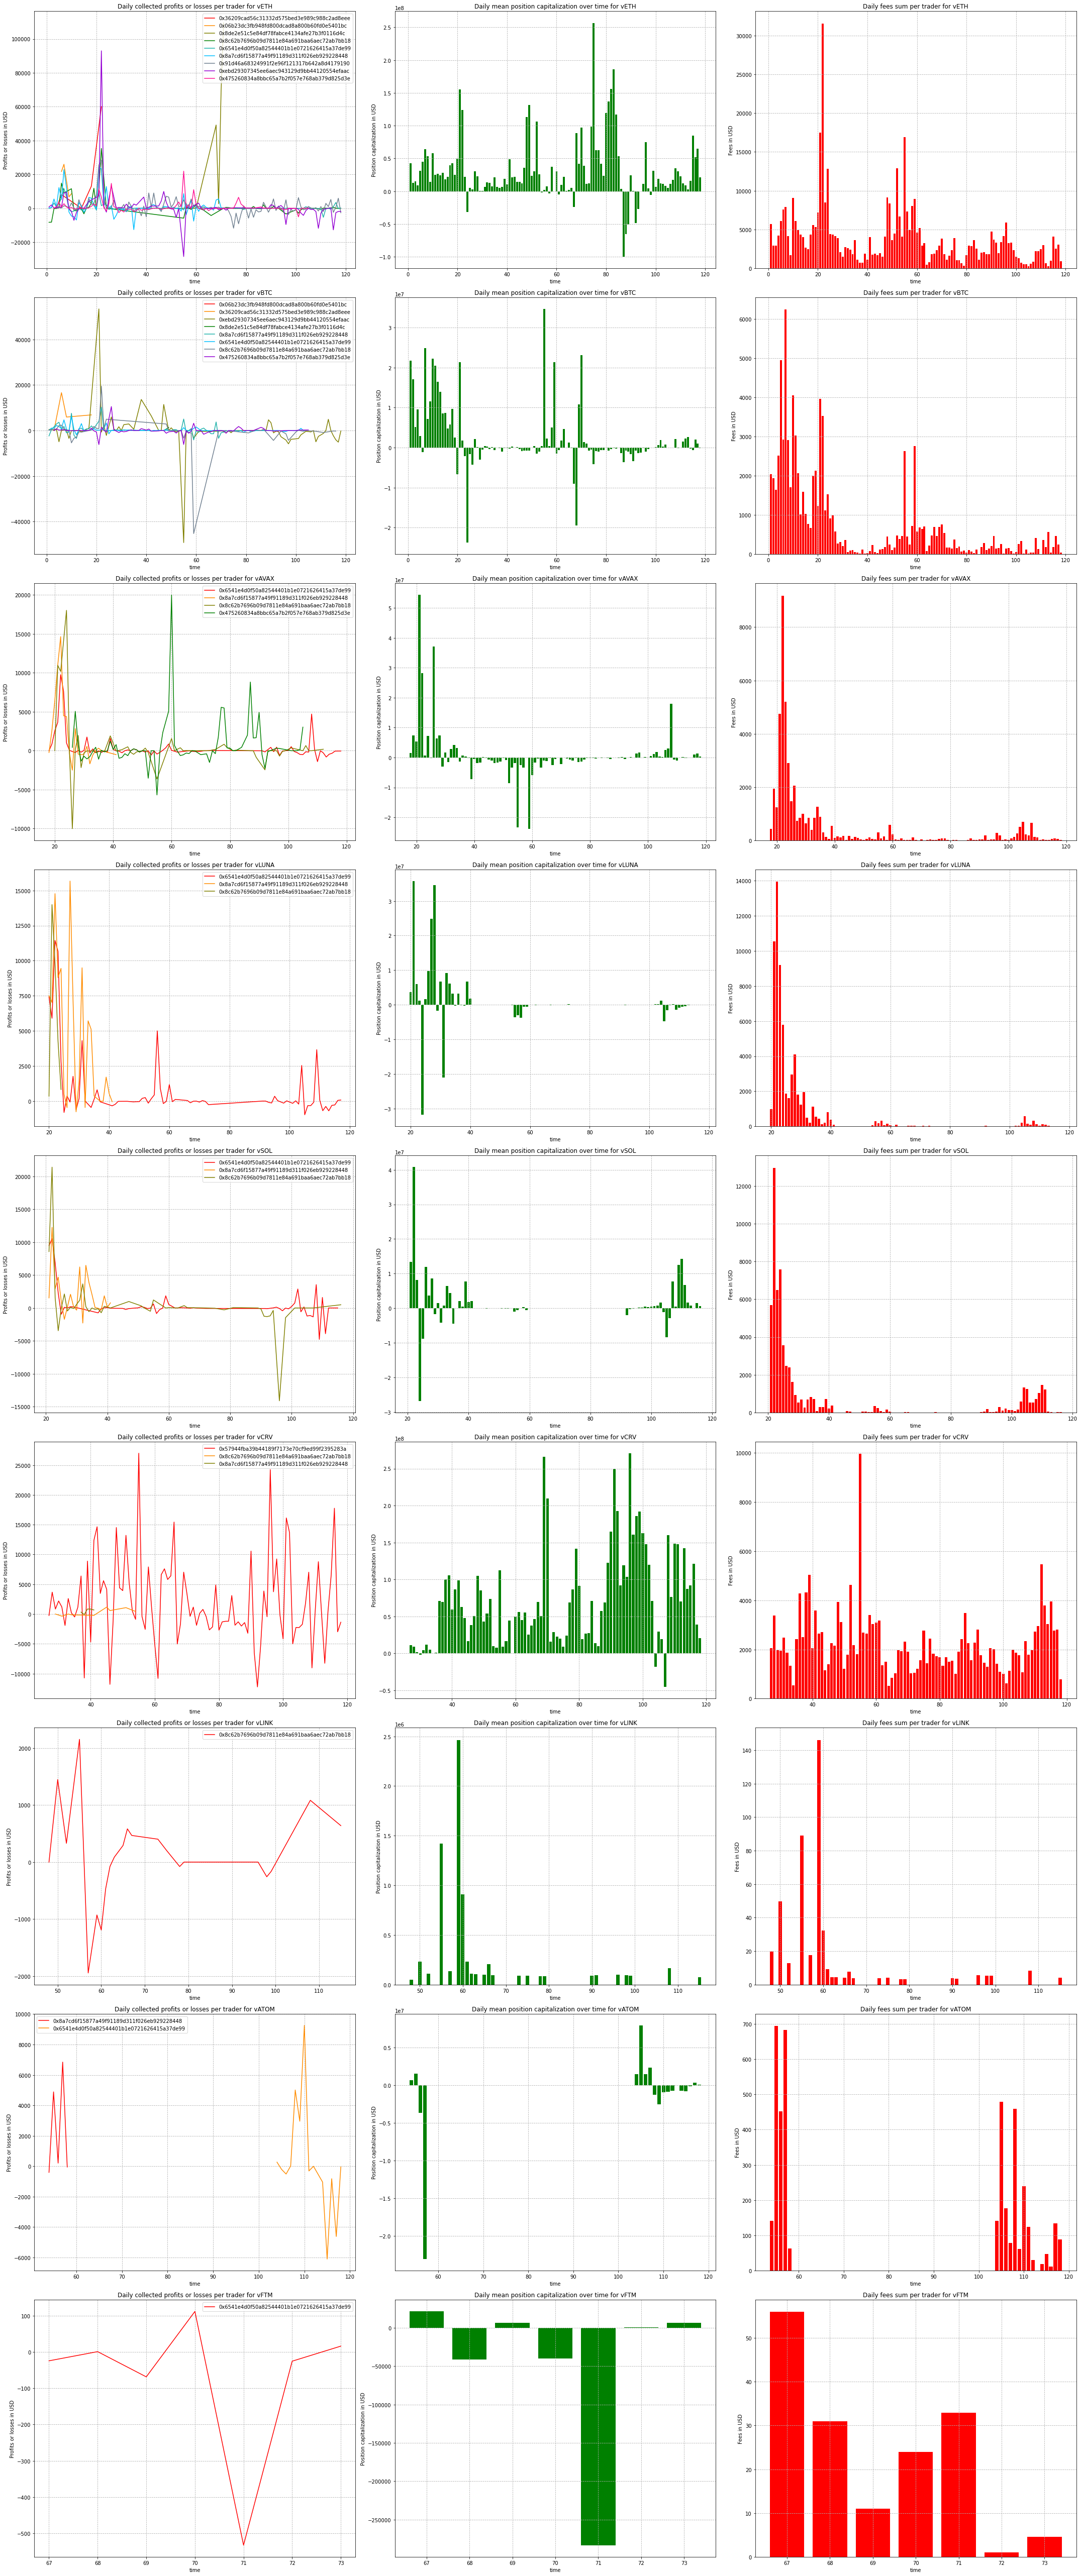

In [18]:
fig = plt.figure(figsize=(30, 150))
top_traders_position_changes_df = position_changes_df[position_changes_df["trader"].isin(top_profiters)]
index = 1
colors = ["red", "darkorange", "olive", "green", "lightseagreen", "deepskyblue", "slategray", "darkviolet", "deeppink", "black"]

for pool in top_traders_position_changes_df["pool_name"].unique():
    pool_top_position_changes_df = top_traders_position_changes_df[top_traders_position_changes_df["pool_name"] == pool]
    ax = fig.add_subplot(19, 3, index)
    sub_index = 0
    for trader in pool_top_position_changes_df["trader"].unique():
        trader_position_changes_df = pool_top_position_changes_df[pool_top_position_changes_df["trader"] == trader]
        grouped_trader_position_changes_df = trader_position_changes_df[["day_of_year", "realized_pnl"]].groupby("day_of_year").sum()
        ax.plot(grouped_trader_position_changes_df[grouped_trader_position_changes_df.index < 200].index,
                grouped_trader_position_changes_df[grouped_trader_position_changes_df.index < 200]["realized_pnl"],
                color=colors[sub_index], label=trader)
        sub_index += 1
    ax.set_xlabel("time")
    ax.set_ylabel("Profits or losses in USD")
    ax.grid(True, linestyle='--')
    ax.legend()
    ax.set_title("Daily collected profits or losses per trader for " + pool)
    index += 1
    
    ax = fig.add_subplot(19, 3, index)
    grouped_pool_top_position_changes_df = pool_top_position_changes_df[["day_of_year", "open_notional"]
                                                                                ].groupby("day_of_year").sum()
    
    ax.bar(grouped_pool_top_position_changes_df[grouped_pool_top_position_changes_df.index < 200].index,
            grouped_pool_top_position_changes_df[grouped_pool_top_position_changes_df.index < 200]["open_notional"],
            color='g')
    ax.set_xlabel("time")
    ax.set_ylabel("Position capitalization in USD")
    ax.grid(True, linestyle='--')
    ax.set_title("Daily mean position capitalization over time for " + pool)
    index += 1
    
    ax = fig.add_subplot(19, 3, index)
    grouped_pool_top_position_changes_df = pool_top_position_changes_df[["day_of_year", "fee"]
                                                                                ].groupby("day_of_year").sum()
    
    ax.bar(grouped_pool_top_position_changes_df[grouped_pool_top_position_changes_df.index < 200].index,
            grouped_pool_top_position_changes_df[grouped_pool_top_position_changes_df.index < 200]["fee"],
            color='r')
    ax.set_xlabel("time")
    ax.set_ylabel("Fees in USD")
    ax.grid(True, linestyle='--')
    ax.set_title("Daily fees sum per trader for " + pool)
    index += 1
    
fig.tight_layout()
plt.show()

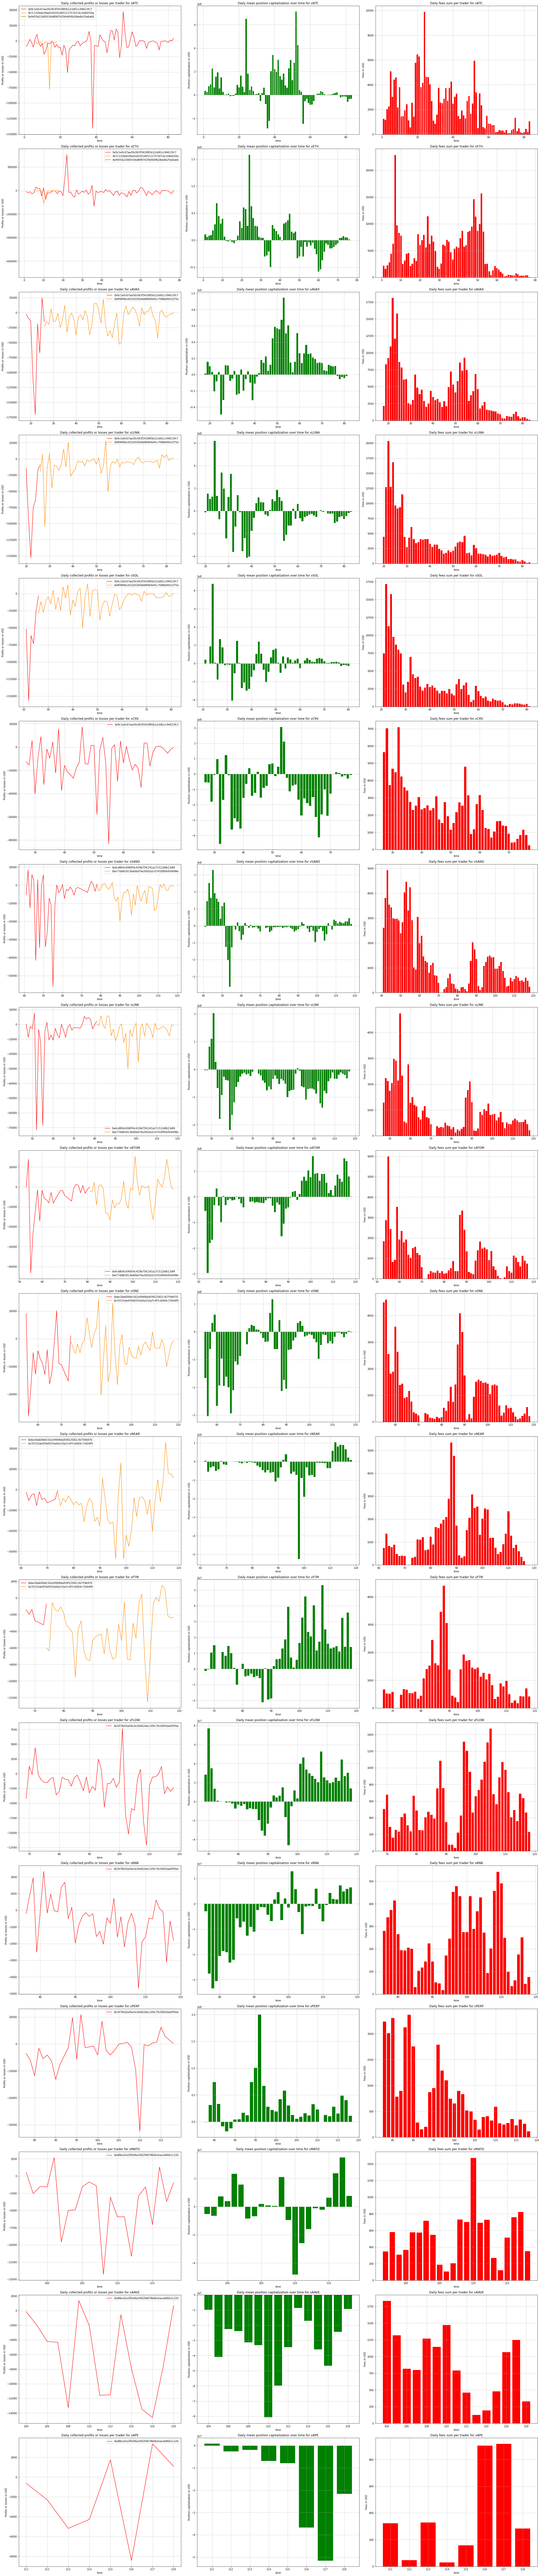

In [19]:
fig = plt.figure(figsize=(30, 150))
top_traders_position_changes_df = position_changes_df[position_changes_df["trader"].isin(top_lossers)]
index = 1
colors = ["red", "darkorange", "olive", "green", "lightseagreen", "deepskyblue", "slategray", "darkviolet", "deeppink", "black"]

for pool in top_traders_position_changes_df["pool_name"].unique():
    pool_top_position_changes_df = top_traders_position_changes_df[top_traders_position_changes_df["pool_name"] == pool]
    ax = fig.add_subplot(19, 3, index)
    sub_index = 0
    for trader in pool_top_position_changes_df["trader"].unique():
        trader_position_changes_df = pool_top_position_changes_df[pool_top_position_changes_df["trader"] == trader]
        grouped_trader_position_changes_df = trader_position_changes_df[["day_of_year", "realized_pnl"]].groupby("day_of_year").sum()
        ax.plot(grouped_trader_position_changes_df[grouped_trader_position_changes_df.index < 200].index,
                grouped_trader_position_changes_df[grouped_trader_position_changes_df.index < 200]["realized_pnl"],
                color=colors[sub_index], label=trader)
        sub_index += 1
    ax.set_xlabel("time")
    ax.set_ylabel("Profits or losses in USD")
    ax.grid(True, linestyle='--')
    ax.legend()
    ax.set_title("Daily collected profits or losses per trader for " + pool)
    index += 1
    
    ax = fig.add_subplot(19, 3, index)
    grouped_pool_top_position_changes_df = pool_top_position_changes_df[["day_of_year", "open_notional"]
                                                                                ].groupby("day_of_year").sum()
    
    ax.bar(grouped_pool_top_position_changes_df[grouped_pool_top_position_changes_df.index < 200].index,
            grouped_pool_top_position_changes_df[grouped_pool_top_position_changes_df.index < 200]["open_notional"],
            color='g')
    ax.set_xlabel("time")
    ax.set_ylabel("Position capitalization in USD")
    ax.grid(True, linestyle='--')
    ax.set_title("Daily mean position capitalization over time for " + pool)
    index += 1
    
    ax = fig.add_subplot(19, 3, index)
    grouped_pool_top_position_changes_df = pool_top_position_changes_df[["day_of_year", "fee"]
                                                                                ].groupby("day_of_year").sum()
    
    ax.bar(grouped_pool_top_position_changes_df[grouped_pool_top_position_changes_df.index < 200].index,
            grouped_pool_top_position_changes_df[grouped_pool_top_position_changes_df.index < 200]["fee"],
            color='r')
    ax.set_xlabel("time")
    ax.set_ylabel("Fees in USD")
    ax.grid(True, linestyle='--')
    ax.set_title("Daily fees sum per trader for " + pool)
    index += 1
    
fig.tight_layout()
plt.show()